# Analyze Portfolio via a standard process

- Gather stocks of interest
- Gather stocks from specific criteria (SP500 top 50...)
- Gather stocks from specific portfolio account
- Assemble stock universe 
- Gather price histories
- Compute aplha factors (X)
    - Compute custom apha factors
    - Compute univeral quant factors
    - Compute date information
- Compute target values (y)
- Generate Optimal Portfolio
- Report on new portfolio

In [2]:
from platform import python_version
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline

import importlib
import trading_functions as tf
importlib.reload(tf)

portfun = tf.Portfolio()
selfun = tf.Selection()

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
importlib.reload(portfolio_optimizer)

import ameritrade_functions as amc
importlib.reload(amc)

plt.rcParams['figure.figsize'] = (20, 8)
print(f'Python version: {python_version()}')
print(f'Pandas version: {pd.__version__}')

Python version: 3.6.12
Pandas version: 0.22.0


## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

In [29]:
username = os.getenv('maiotradeuser')
password = os.getenv('maiotradepw')
client_id = os.getenv('maiotradeclientid')

masked_account_number = '#---5311'
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = 'data/price_histories_20210424.csv'

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but that has not been coded yet.)

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

In [32]:
td_ameritrade = amc.AmeritradeRest(username, password, client_id)
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    print('Error: No authorization data: {}'.format(td_ameritrade.authorization))
else:
    print('You have authorization')

You have authorization


In [33]:
import trading_factors as alpha_factors
importlib.reload(alpha_factors)
import alphalens as al

def generate_portfolio(investment_amount, stock_universe, price_histories, risk_cap=0.05,weights_max=0.12, weights_min=-0.12, num_factor_exposures=10):
    print(f'Investment amount: {investment_amount}')
    pricing = datafun.get_close_values(price_histories)
    returns = retfun.compute_returns(pricing)
    
    all_factors = pd.concat(
    [
        alpha_factors.momentum(price_histories, 252),
        alpha_factors.mean_reversion_factor_returns_smoothed(price_histories, 5),
        alpha_factors.overnight_sentiment_smoothed(price_histories, 5)
    ], axis=1)
    all_factors.sort_index(inplace=True)

    assets = all_factors.index.levels[1].values.tolist()
    clean_factor_data, unixt_factor_data = alpha_factors.prepare_alpha_lense_factor_data(all_factors, pricing)
    
    
    """
    ls_factor_tears = pd.DataFrame()
    for factor, factor_data in clean_factor_data.items():
        print('Factor: ', factor)
        ls_factor_tears[factor] = al.tears.create_full_tear_sheet(factor_data, long_short=False, group_neutral=False, by_group=False)
        
    display(ls_factor_tears)
    """        
    risk_model = alpha_factors.RiskModelPCA(returns, 1, num_factor_exposures)
    print(f'portfolio variance is:  {risk_model.compute_portfolio_variance(sotck_universe_weights):.8f}')
    
    ls_factor_returns = pd.DataFrame()

    for factor, factor_data in clean_factor_data.items():
        ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]
        
    (1+ls_factor_returns).cumprod().plot()
        
    qr_factor_returns = pd.DataFrame()

    for factor, factor_data in unixt_factor_data.items():
        qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

    (10000*qr_factor_returns).plot.bar(
        subplots=True,
        sharey=True,
        layout=(4,2),
        figsize=(14, 14),
        legend=False)
    
    ls_FRA = pd.DataFrame()

    for factor, factor_data in unixt_factor_data.items():
        ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

    ls_FRA.plot(title="Factor Rank Autocorrelation")
    
    factor_sharp_ratio = alpha_factors.sharpe_ratio(ls_factor_returns, 'daily')
    print(factor_sharp_ratio.round(2))
    
    selected_factors = all_factors.columns[[idx for idx, element in enumerate(factor_sharp_ratio.values) if element >= 0.9]]
    print(selected_factors)
    print('Selected Factors: {}'.format(', '.join(selected_factors)))

    all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
    alphas = all_factors[['alpha_vector']]

    alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]
    
    optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
    print(f'Old portfolio variance is:  {risk_model.compute_portfolio_variance(sotck_universe_weights):.8f}')
    print(f'New portfolio variance is:  {risk_model.compute_portfolio_variance(optimal_weights):.8f}')
    optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
    
    print(f'Current investment amount: {investment_amount}')
    optimal_weights['amount'] = (optimal_weights['optimalWeights'] * investment_amount).round(0)
    optimal_weights['marketValue'] = stock_universe_values['marketValue']
    optimal_weights['buy/sell'] = (optimal_weights['marketValue'] - optimal_weights['amount']) * -1
    optimal_weights['close'] = pricing.iloc[-1]
    optimal_weights['deltaShares'] = (optimal_weights['buy/sell'] / optimal_weights['close']).round(0)
    optimal_weights['deltaMarketValue'] = (optimal_weights['deltaShares'] * optimal_weights['close'])
    optimal_weights['totalShares'] = optimal_weights['deltaShares']
    optimal_weights['totalMarketValue'] = (optimal_weights['totalShares'] * optimal_weights['close'])
    return optimal_weights[(optimal_weights['totalShares'] > 0) & (optimal_weights['deltaShares'] != 0)].round(2)

In [34]:
from trading_functions import Data

symbols_of_interest = ['MGM', 'PDYPF', 'NNXPF']
# Hardcoded for now
symbols_via_specific_criteria = ['AAPL',
                                 'MSFT',
                                 'GOOG',
                                 'TSLA',
                                 'COKE',
                                 'IBM',
                                 'BABA',
                                 'GMGMF',
                                 'OEG',
                                 'LX',
                                 'AIH',
                                 'NMRD',
                                 'CAN',
                                 'MOSY',
                                 'QFIN',
                                 'OCG',
                                 'PRTK',
                                 'ZKIN', 
                                 'EFOI',
                                 'CONN',
                                 'LEDS',
                                 'TELL',
                                 'JZXN',
                                 'VTNR',
                                 'AEI',
                                 'IPQ',
                                 'RCON'
                                ]

# Specific Portfolio Account
account_portfolio_df = Data().get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
equity_investments_df = portfun.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
symbols_from_account = list(equity_investments_df['symbol'].values)

stock_universe = set(symbols_of_interest + symbols_via_specific_criteria + symbols_from_account)

In [35]:
non_portfolio_symbols = stock_universe - set(symbols_from_account)
non_portfolio_values = pd.DataFrame.from_dict({ symbol : [0, 0] for symbol in non_portfolio_symbols}, orient='index')
non_portfolio_values.index.name='symbol'
non_portfolio_values.columns = ['marketValue', 'longQuantity']
stock_universe_values = portfun.get_market_values(equity_investments_df).append(non_portfolio_values)
sotck_universe_weights = portfun.get_portfolio_weights(stock_universe_values)
display(sotck_universe_weights)

symbol
AAPL     0.000000
AEI      0.000000
AIH      0.000000
BABA     0.000000
CAN      0.000000
COKE     0.000000
CONN     0.000000
DKNG     0.018920
EEENF    0.000030
EFOI     0.000000
FGPHF    0.062464
FNCL     0.027842
GMGMF    0.000000
GOOG     0.000000
IBM      0.000000
IPQ      0.000000
JZXN     0.000000
LEDS     0.000000
LX       0.000000
MGM      0.000000
MOSY     0.000000
MSFT     0.000000
NMRD     0.000000
NNXPF    0.000000
OCG      0.000000
OEG      0.000000
PDYPF    0.000000
PRTK     0.000000
QFIN     0.000000
RCON     0.000000
SCHA     0.016469
SCHF     0.070777
SCHM     0.048582
TELL     0.000000
TLRY     0.117420
TSLA     0.000000
VBK      0.014571
VBR      0.017592
VGK      0.073630
VTI      0.286431
VTNR     0.000000
VXF      0.048509
WKHS     0.196762
ZKIN     0.000000
dtype: float64

# Price History data

One you have a set of investments you want to work with, you will need to pull some historical data for them.

In [36]:
from trading_functions import Returns
from trading_functions import Data
number_of_years = 5
price_histories = td_ameritrade.get_price_histories(stock_universe, datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
returns = Returns().compute_returns(Data().get_close_values(price_histories))
pricing = Data().get_close_values(price_histories)

Empty candle data for IPQ


## Factors

In [88]:
import trading_factors as alpha_factors
importlib.reload(alpha_factors)
import alphalens as al

In [127]:
all_factors = pd.concat(
[
    alpha_factors.FactorMomentum(price_histories, 252).demean().rank().zscore().for_al(),
    alpha_factors.FactorMeanReversion(price_histories, 5).demean().rank().zscore().smoothed().rank().zscore().for_al(),
    alpha_factors.OvernightSentiment(price_histories, 5).demean().rank().zscore().smoothed(10).rank().zscore().for_al()
], axis=1).dropna()
all_factors.sort_index(inplace=True)

## Universal Quant Features

- Volatility 
- Dollar Volume
- Market Dispersion
- Market Volatility

In [128]:
all_factors = pd.concat(
[
    all_factors,
    alpha_factors.AnnualizedVolatility(price_histories, 20).rank().zscore().for_al(),
    alpha_factors.AnnualizedVolatility(price_histories, 120).rank().zscore().for_al(),
    alpha_factors.AverageDollarVolume(price_histories, 20).rank().zscore().for_al(),
    alpha_factors.AverageDollarVolume(price_histories, 120).rank().zscore().for_al(),
    alpha_factors.MarketDispersion(price_histories, 20).for_al(),
    alpha_factors.MarketDispersion(price_histories, 120).for_al(),
    alpha_factors.MarketVolatility(price_histories, 20).for_al(),
    alpha_factors.MarketVolatility(price_histories, 120).for_al()
], axis=1).dropna()
all_factors.sort_index(inplace=True)

In [129]:
alpha_factors.FactorDateParts(all_factors)
all_factors = pd.get_dummies(all_factors, columns=['weekday', 'quarter'])
all_factors.head()

momentum_252_day_logret  \
date       ticker                            
2017-06-05 AAPL                   1.235129   
           AEI                   -0.658736   
           AIH                   -0.658736   
           BABA                   1.399813   
           CAN                   -0.658736   

                   mean_reversion_5_day_logret_smoothed  \
date       ticker                                         
2017-06-05 AAPL                               -0.823419   
           AEI                                 0.329368   
           AIH                                 0.329368   
           BABA                               -1.646839   
           CAN                                 0.329368   

                   overnight_sentiment_5_day_smoothed  \
date       ticker                                       
2017-06-05 AAPL                              0.805945   
           AEI                              -1.370106   
           AIH                              -1.531295   
           BABA                              0.644756   
           CAN                              -1.611889   

                   annualzed_volatility_20_day  annualzed_volatility_120_day  \
date       ticker                                                              
2017-06-05 AAPL                       0.411710                      0.164684   
           AEI                       -1.152787                     -1.152787   
           AIH                       -1.152787                     -1.152787   
           BABA                       0.000000                      0.905761   
           CAN                       -1.152787                     -1.152787   

                   average_dollar_volume_20_day  \
date       ticker                                 
2017-06-05 AAPL                        1.737419   
           AEI                        -1.116912   
           AIH                        -1.116912   
           BABA                        1.489216   
           CAN                        -1.116912   

                   average_dollar_volume_120_day  market_dispersion20_day  \
date       ticker                                                           
2017-06-05 AAPL                         1.722068                 0.032406   
           AEI                         -1.189047                 0.032406   
           AIH                         -1.189047                 0.032406   
           BABA                         1.394055                 0.032406   
           CAN                         -1.189047                 0.032406   

                   market_dispersion120_day  market_volatility20_day  \
date       ticker                                                      
2017-06-05 AAPL                    0.027217                 0.076871   
           AEI                     0.027217                 0.076871   
           AIH                     0.027217                 0.076871   
           BABA                    0.027217                 0.076871   
           CAN                     0.027217                 0.076871   

                     ...      quarter_end  weekday_0  weekday_1  weekday_2  \
date       ticker    ...                                                     
2017-06-05 AAPL      ...                0          1          0          0   
           AEI       ...                0          1          0          0   
           AIH       ...                0          1          0          0   
           BABA      ...                0          1          0          0   
           CAN       ...                0          1          0          0   

                   weekday_3  weekday_4  quarter_1  quarter_2  quarter_3  \
date       ticker                                                          
2017-06-05 AAPL            0          0          0          1          0   
           AEI             0          0          0          1          0   
           AIH             0          0          0          1      

## Compute the target values (y)

In [130]:
all_factors = pd.concat(
[
    all_factors,
    alpha_factors.FactorReturnQuantiles(price_histories, 5, 5).for_al()
], axis=1).dropna()
all_factors.sort_index(inplace=True)
all_factors.head()

momentum_252_day_logret  \
date       ticker                            
2017-06-05 AAPL                   1.235129   
           AEI                   -0.658736   
           AIH                   -0.658736   
           BABA                   1.399813   
           CAN                   -0.658736   

                   mean_reversion_5_day_logret_smoothed  \
date       ticker                                         
2017-06-05 AAPL                               -0.823419   
           AEI                                 0.329368   
           AIH                                 0.329368   
           BABA                               -1.646839   
           CAN                                 0.329368   

                   overnight_sentiment_5_day_smoothed  \
date       ticker                                       
2017-06-05 AAPL                              0.805945   
           AEI                              -1.370106   
           AIH                              -1.531295   
           BABA                              0.644756   
           CAN                              -1.611889   

                   annualzed_volatility_20_day  annualzed_volatility_120_day  \
date       ticker                                                              
2017-06-05 AAPL                       0.411710                      0.164684   
           AEI                       -1.152787                     -1.152787   
           AIH                       -1.152787                     -1.152787   
           BABA                       0.000000                      0.905761   
           CAN                       -1.152787                     -1.152787   

                   average_dollar_volume_20_day  \
date       ticker                                 
2017-06-05 AAPL                        1.737419   
           AEI                        -1.116912   
           AIH                        -1.116912   
           BABA                        1.489216   
           CAN                        -1.116912   

                   average_dollar_volume_120_day  market_dispersion20_day  \
date       ticker                                                           
2017-06-05 AAPL                         1.722068                 0.032406   
           AEI                         -1.189047                 0.032406   
           AIH                         -1.189047                 0.032406   
           BABA                         1.394055                 0.032406   
           CAN                         -1.189047                 0.032406   

                   market_dispersion120_day  market_volatility20_day  \
date       ticker                                                      
2017-06-05 AAPL                    0.027217                 0.076871   
           AEI                     0.027217                 0.076871   
           AIH                     0.027217                 0.076871   
           BABA                    0.027217                 0.076871   
           CAN                     0.027217                 0.076871   

                             ...             weekday_0  weekday_1  weekday_2  \
date       ticker            ...                                               
2017-06-05 AAPL              ...                   1.0        0.0        0.0   
           AEI               ...                   1.0        0.0        0.0   
           AIH               ...                   1.0        0.0        0.0   
           BABA              ...                   1.0        0.0        0.0   
           CAN               ...                   1.0        0.0        0.0   

                   weekday_3  weekday_4  quarter_1  quarter_2  quarter_3  \
date       ticker                                                          
2017-06-05 AAPL          0.0        0.0        0.0        1.0        0.0   
           AEI           0.0        0.0        0.0        1.0        0.0   
           AIH           0.0        0.0        0.0   

In [131]:
all_factors.to_csv('data/factor_features_data.csv')

In [132]:
all_factors = pd.read_csv('data/factor_features_data.csv')
all_factors.set_index(['date', 'ticker'], inplace=True)
all_factors.sort_index(inplace=True)
all_factors.head()

momentum_252_day_logret  \
date       ticker                            
2017-06-05 AAPL                   1.235129   
           AEI                   -0.658736   
           AIH                   -0.658736   
           BABA                   1.399813   
           CAN                   -0.658736   

                   mean_reversion_5_day_logret_smoothed  \
date       ticker                                         
2017-06-05 AAPL                               -0.823419   
           AEI                                 0.329368   
           AIH                                 0.329368   
           BABA                               -1.646839   
           CAN                                 0.329368   

                   overnight_sentiment_5_day_smoothed  \
date       ticker                                       
2017-06-05 AAPL                              0.805945   
           AEI                              -1.370106   
           AIH                              -1.531295   
           BABA                              0.644756   
           CAN                              -1.611889   

                   annualzed_volatility_20_day  annualzed_volatility_120_day  \
date       ticker                                                              
2017-06-05 AAPL                       0.411710                      0.164684   
           AEI                       -1.152787                     -1.152787   
           AIH                       -1.152787                     -1.152787   
           BABA                       0.000000                      0.905761   
           CAN                       -1.152787                     -1.152787   

                   average_dollar_volume_20_day  \
date       ticker                                 
2017-06-05 AAPL                        1.737419   
           AEI                        -1.116912   
           AIH                        -1.116912   
           BABA                        1.489216   
           CAN                        -1.116912   

                   average_dollar_volume_120_day  market_dispersion20_day  \
date       ticker                                                           
2017-06-05 AAPL                         1.722068                 0.032406   
           AEI                         -1.189047                 0.032406   
           AIH                         -1.189047                 0.032406   
           BABA                         1.394055                 0.032406   
           CAN                         -1.189047                 0.032406   

                   market_dispersion120_day  market_volatility20_day  \
date       ticker                                                      
2017-06-05 AAPL                    0.027217                 0.076871   
           AEI                     0.027217                 0.076871   
           AIH                     0.027217                 0.076871   
           BABA                    0.027217                 0.076871   
           CAN                     0.027217                 0.076871   

                             ...             weekday_0  weekday_1  weekday_2  \
date       ticker            ...                                               
2017-06-05 AAPL              ...                   1.0        0.0        0.0   
           AEI               ...                   1.0        0.0        0.0   
           AIH               ...                   1.0        0.0        0.0   
           BABA              ...                   1.0        0.0        0.0   
           CAN               ...                   1.0        0.0        0.0   

                   weekday_3  weekday_4  quarter_1  quarter_2  quarter_3  \
date       ticker                                                          
2017-06-05 AAPL          0.0        0.0        0.0        1.0        0.0   
           AEI           0.0        0.0        0.0        1.0        0.0   
           AIH           0.0        0.0        0.0   

In [133]:
features = list(all_factors.columns[:-1])
targets = list(all_factors.columns[-1:])[0]
features, targets

(['momentum_252_day_logret',
  'mean_reversion_5_day_logret_smoothed',
  'overnight_sentiment_5_day_smoothed',
  'annualzed_volatility_20_day',
  'annualzed_volatility_120_day',
  'average_dollar_volume_20_day',
  'average_dollar_volume_120_day',
  'market_dispersion20_day',
  'market_dispersion120_day',
  'market_volatility20_day',
  'market_volatility120_day',
  'is_January',
  'is_December',
  'year',
  'month_start',
  'month_end',
  'quarter_start',
  'quarter_end',
  'weekday_0',
  'weekday_1',
  'weekday_2',
  'weekday_3',
  'weekday_4',
  'quarter_1',
  'quarter_2',
  'quarter_3',
  'quarter_4'],
 'logret_5_day_5_quantiles')

In [134]:
def make_splits(df, features, target, split_valid=0.20, split_test=0.20):
    temp = df.dropna()
    
    X = temp[features].copy()
    y = temp[target].copy()

    train_end = int(X.shape[0]*(1-split_valid-split_test))
    valid_end = train_end + int(X.shape[0]*split_valid)

    X_train, X_valid, X_test = X.iloc[:train_end,], X.iloc[(train_end+1):valid_end,], X.iloc[(valid_end+1):]
    y_train, y_valid, y_test = y.iloc[:train_end,], y.iloc[(train_end+1):valid_end,], y.iloc[(valid_end+1):]
    
    return X, X_train, X_valid, X_test, y_train, y_valid, y_test

In [136]:
X, X_train, X_valid, X_test, y_train, y_valid, y_testj = make_splits(all_factors, features, targets)

In [137]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
clf = RandomForestClassifier(
        n_estimators=100,
        max_features='sqrt',
        min_samples_split=500,
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        criterion='entropy',
        verbose=0,
        random_state=42
    )

In [118]:
clf = BaggingClassifier(
        base_estimator=clf, 
        n_estimators=100,
        bootstrap=True, 
        oob_score=True, 
        random_state=42, 
        max_samples=0.2)

In [138]:
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_split=500, n_jobs=-1, oob_score=True,
                       random_state=42)

In [106]:
import shap
shap.initjs() #initialize javascript to enable visualizations

def model_shap_importances(model, features, X, tree_limit=50):
    """
    Note that the observations should be numeric (integer or float).
    So booleans should be converted to 1 (True) and 0 (False) 
    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X, tree_limit=tree_limit, check_additivity=False)
    
    shap_values_matrix = np.concatenate(shap_values)
    
    shap_abs = np.abs(shap_values_matrix)
    
    global_importances = np.nanmean(shap_abs, axis=0)
        
    indices = np.argsort(global_importances)[::-1]
    features_ranked = []
    for f in range(X.shape[1]):
        print("%d. %s (%d) (%f)" % (f+1,features[indices[f]], indices[f], global_importances[indices[f]]))
        features_ranked.append(features[indices[f]])
        
    return features_ranked

In [139]:
features_ranked = model_shap_importances(clf,features,X_train,10)

1. average_dollar_volume_20_day (5) (0.006149)
2. annualzed_volatility_120_day (4) (0.004167)
3. average_dollar_volume_120_day (6) (0.004038)
4. annualzed_volatility_20_day (3) (0.003373)
5. mean_reversion_5_day_logret_smoothed (1) (0.001784)
6. momentum_252_day_logret (0) (0.001555)
7. market_dispersion20_day (7) (0.000931)
8. market_volatility20_day (9) (0.000597)
9. year (13) (0.000588)
10. overnight_sentiment_5_day_smoothed (2) (0.000557)
11. market_dispersion120_day (8) (0.000456)
12. quarter_4 (26) (0.000396)
13. market_volatility120_day (10) (0.000370)
14. is_January (11) (0.000175)
15. quarter_3 (25) (0.000161)
16. quarter_1 (23) (0.000117)
17. is_December (12) (0.000116)
18. quarter_2 (24) (0.000067)
19. weekday_4 (22) (0.000020)
20. month_end (15) (0.000012)
21. weekday_1 (19) (0.000006)
22. month_start (14) (0.000005)
23. quarter_end (17) (0.000004)
24. weekday_0 (18) (0.000000)
25. quarter_start (16) (0.000000)
26. weekday_2 (20) (0.000000)
27. weekday_3 (21) (0.000000)


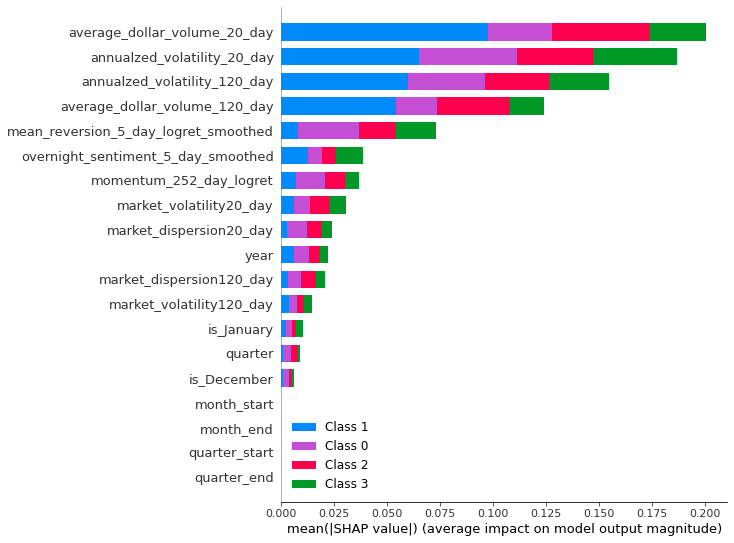

In [125]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train, tree_limit=100)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [114]:
def model_score(m, X_train, y_train, X_valid, y_valid):
    '''
    Take in the model and training and validation datasets, and return the training accuracy score, validation
    accuracy score, and out-of-bag score. Furthermore, print each of these results.
    
    Parameters
    ----------
    m : RandomForestClassifier instance
        The trained model.
        
    X_train : pandas DataFrame
        The training features.
        
    y_train : pandas Series
        The training labels.
        
    X_valid : pandas DataFrame
        The validation features.
        
    y_valid : pandas Series
        The validation labels.
    
    Returns
    -------
    train_score : float
        The mean training accuracy.
        
    valid_score : float
        The mean validation accuracy.
        
    oob_score : float
        The out-of-bag score.
    
    '''

    # TODO: Implement
    train_score = m.score(X_train, y_train)
    valid_score = m.score(X_valid, y_valid)
    oob_score = m.oob_score_
    
    
    return train_score, valid_score, oob_score

def instantiate_and_fit_a_rf(n_estimators, X_train, y_train, min_samples_leaf=5):
    """
    Instantiate a random forest classifier and fit it on the training data. Return the fitted classifier.
    Make sure you use bootstrapping and calculate an out-of-bag score. Set `random_state` equal to an integer so that
    when you fit the model again you get the same result. 
    
    Parameters
    ----------
    n_estimators : int
        The number of trees.
    
    X_train : pandas DataFrame
        The training features.
        
    y_train : pandas Series
        The training labels.
    
    Returns
    -------
    clf : RandomForestClassifier
        The fitted classifier instance.
    """
    
    # TODO: Implement
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=3,
                                   min_samples_leaf=min_samples_leaf,
                                   max_features='sqrt',
                                   bootstrap=True,
                                   criterion='entropy',
                                   random_state=42,
                                   oob_score=True)
    model.fit(X_train, y_train)
    
    return model

def plot_results(tree_sizes, train_score, oob_score, valid_score, title, y_range):
    plt.plot(tree_sizes, train_score, 'xb-');
    plt.plot(tree_sizes, oob_score, 'xg-');
    plt.plot(tree_sizes, valid_score, 'xr-');
    plt.title(title);
    plt.xlabel('Number of Trees');
    plt.ylabel('Accuracy')
    plt.legend(['train','oob', 'valid'])
    plt.ylim(y_range[0], y_range[1]);

In [115]:
model_score(clf, X_train, y_train, X_valid, y_valid)

(0.6343725943033103, 0.488509065711976, 0.6225173210161663)

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\nmaiorana\anaconda3\envs\ai-for-trading\lib\site-packages\sklearn\ensemble\_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


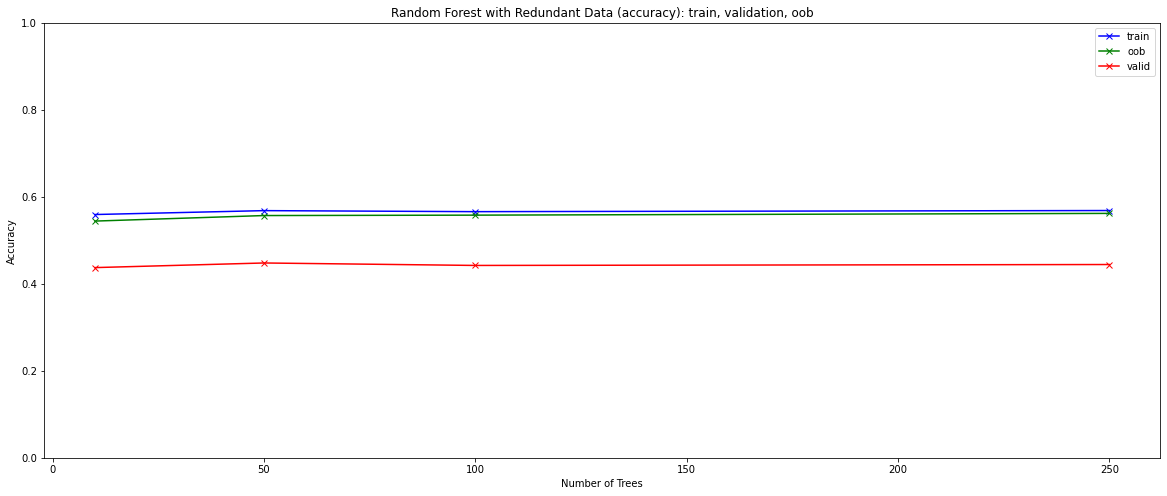

In [66]:
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm as tqdm

train_score = []
valid_score = []
oob_score = []
tree_sizes = [10, 50, 100, 250]

for trees in tqdm(tree_sizes):
    clf_red = instantiate_and_fit_a_rf(trees, X_train, y_train)
    
    tr, va, oob = model_score(clf_red, X_train, y_train, X_valid, y_valid)
    train_score.append(tr); valid_score.append(va); oob_score.append(oob)

plot_results(
    tree_sizes, 
    train_score, 
    oob_score, 
    valid_score, 
    'Random Forest with Redundant Data (accuracy): train, validation, oob',
    range(5))

### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

In [ ]:
optimal_weights = OptimalHoldings(risk_cap=0.05,weights_max=0.12, weights_min=-0.12).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)
print(f'Old portfolio variance is:  {risk_model.compute_portfolio_variance(sotck_universe_weights):.8f}')
print(f'New portfolio variance is:  {risk_model.compute_portfolio_variance(optimal_weights):.8f}')
display((optimal_weights*100).round(2))
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')

#x_axis = plt.axes().get_xaxis()
#x_axis.set_visible(False)

In [ ]:
investment_amount = portfun.get_account_value(stock_universe_values).round(2)
print(f'Current investment amount: {investment_amount}')
optimal_weights['amount'] = (optimal_weights['optimalWeights'] * investment_amount).round(0)
optimal_weights['marketValue'] = stock_universe_values['marketValue']
optimal_weights['buy/sell'] = (optimal_weights['marketValue'] - optimal_weights['amount']) * -1
optimal_weights['close'] = pricing.iloc[-1]
optimal_weights['existingShares'] = stock_universe_values['longQuantity']
optimal_weights['deltaShares'] = (optimal_weights['buy/sell'] / optimal_weights['close']).round(0)
optimal_weights['deltaMarketValue'] = (optimal_weights['deltaShares'] * optimal_weights['close'])
optimal_weights['totalShares'] = (optimal_weights['existingShares'] + optimal_weights['deltaShares'])
optimal_weights['totalMarketValue'] = (optimal_weights['totalShares'] * optimal_weights['close'])
optimal_weights

## Think or Swim Simulator

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] <= 0) & (optimal_weights['deltaShares'] == 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)][['deltaMarketValue', 'totalMarketValue']].sum().round(2)